Graph has 7115 nodes and 103689 edges.
Graph after filtering has 913 nodes and 5854 reciprocal edges.
[(3352, 72), (3352, 825), (3352, 1166), (3352, 1247), (3352, 1549), (3352, 1769), (3352, 2257), (3352, 2289), (3352, 2297), (3352, 2326), (3352, 2328), (3352, 2381), (3352, 2398), (3352, 2485), (3352, 2535), (3352, 2544), (3352, 2565), (3352, 2595), (3352, 2654), (3352, 2655), (3352, 2660), (3352, 2693), (3352, 2696), (3352, 2747), (3352, 2775), (3352, 2790), (3352, 2859), (3352, 2871), (3352, 2909), (3352, 2958), (3352, 3026), (3352, 3028), (3352, 3084), (3352, 3144), (3352, 3258), (3352, 3291), (3352, 3394), (3352, 3404), (3352, 3447), (3352, 3452), (3352, 3454), (3352, 3456), (3352, 3568), (3352, 3607), (3352, 3615), (3352, 3631), (3352, 3635), (3352, 3660), (3352, 3661), (3352, 3664), (3352, 3691), (3352, 3812), (3352, 3813), (3352, 3910), (3352, 3976), (3352, 4040), (3352, 4124), (3352, 4266), (3352, 4355), (3352, 4531), (72, 178), (72, 226), (72, 371), (72, 407), (72, 600), (72, 

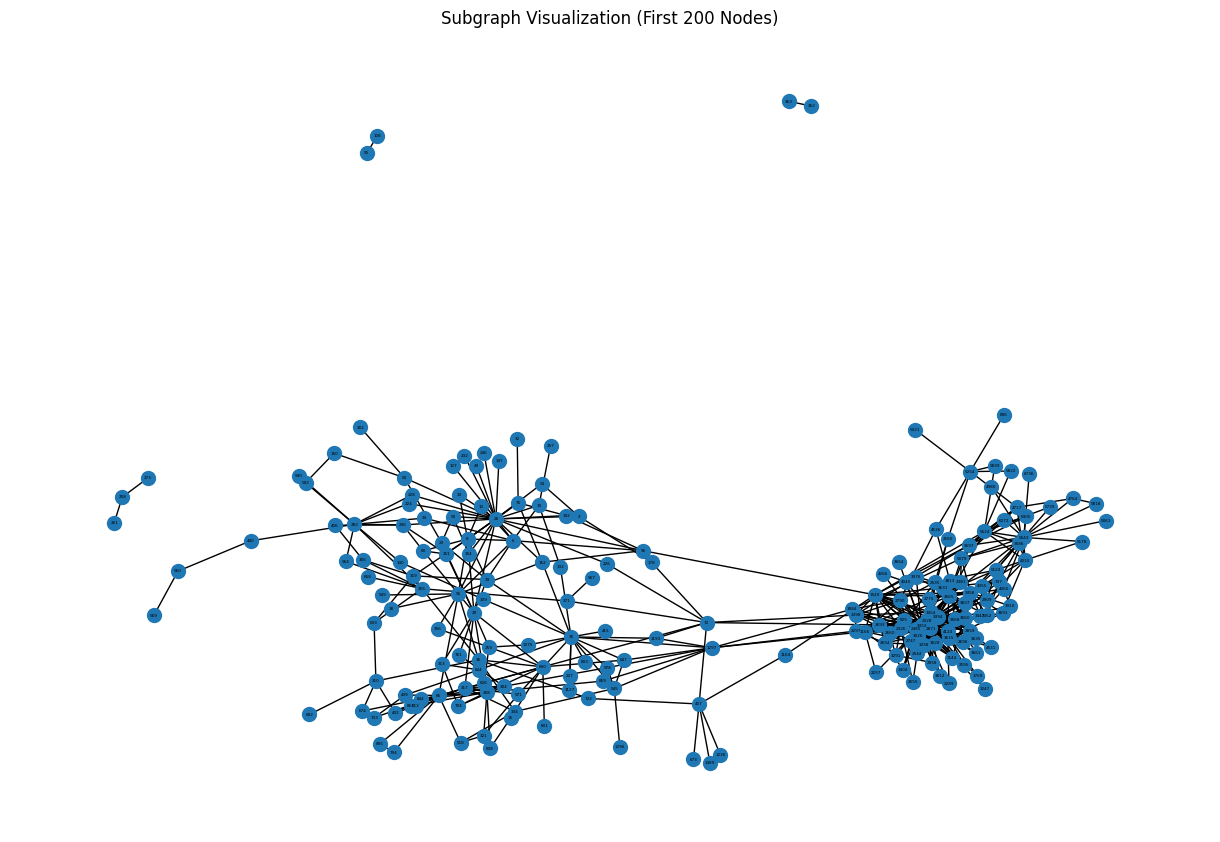

Graph Summary:
- Number of nodes: 200
- Number of edges: 524
- Largest clique size: 6
- Nodes in the largest clique: [2328, 2485, 2565, 2747, 3026, 3352]


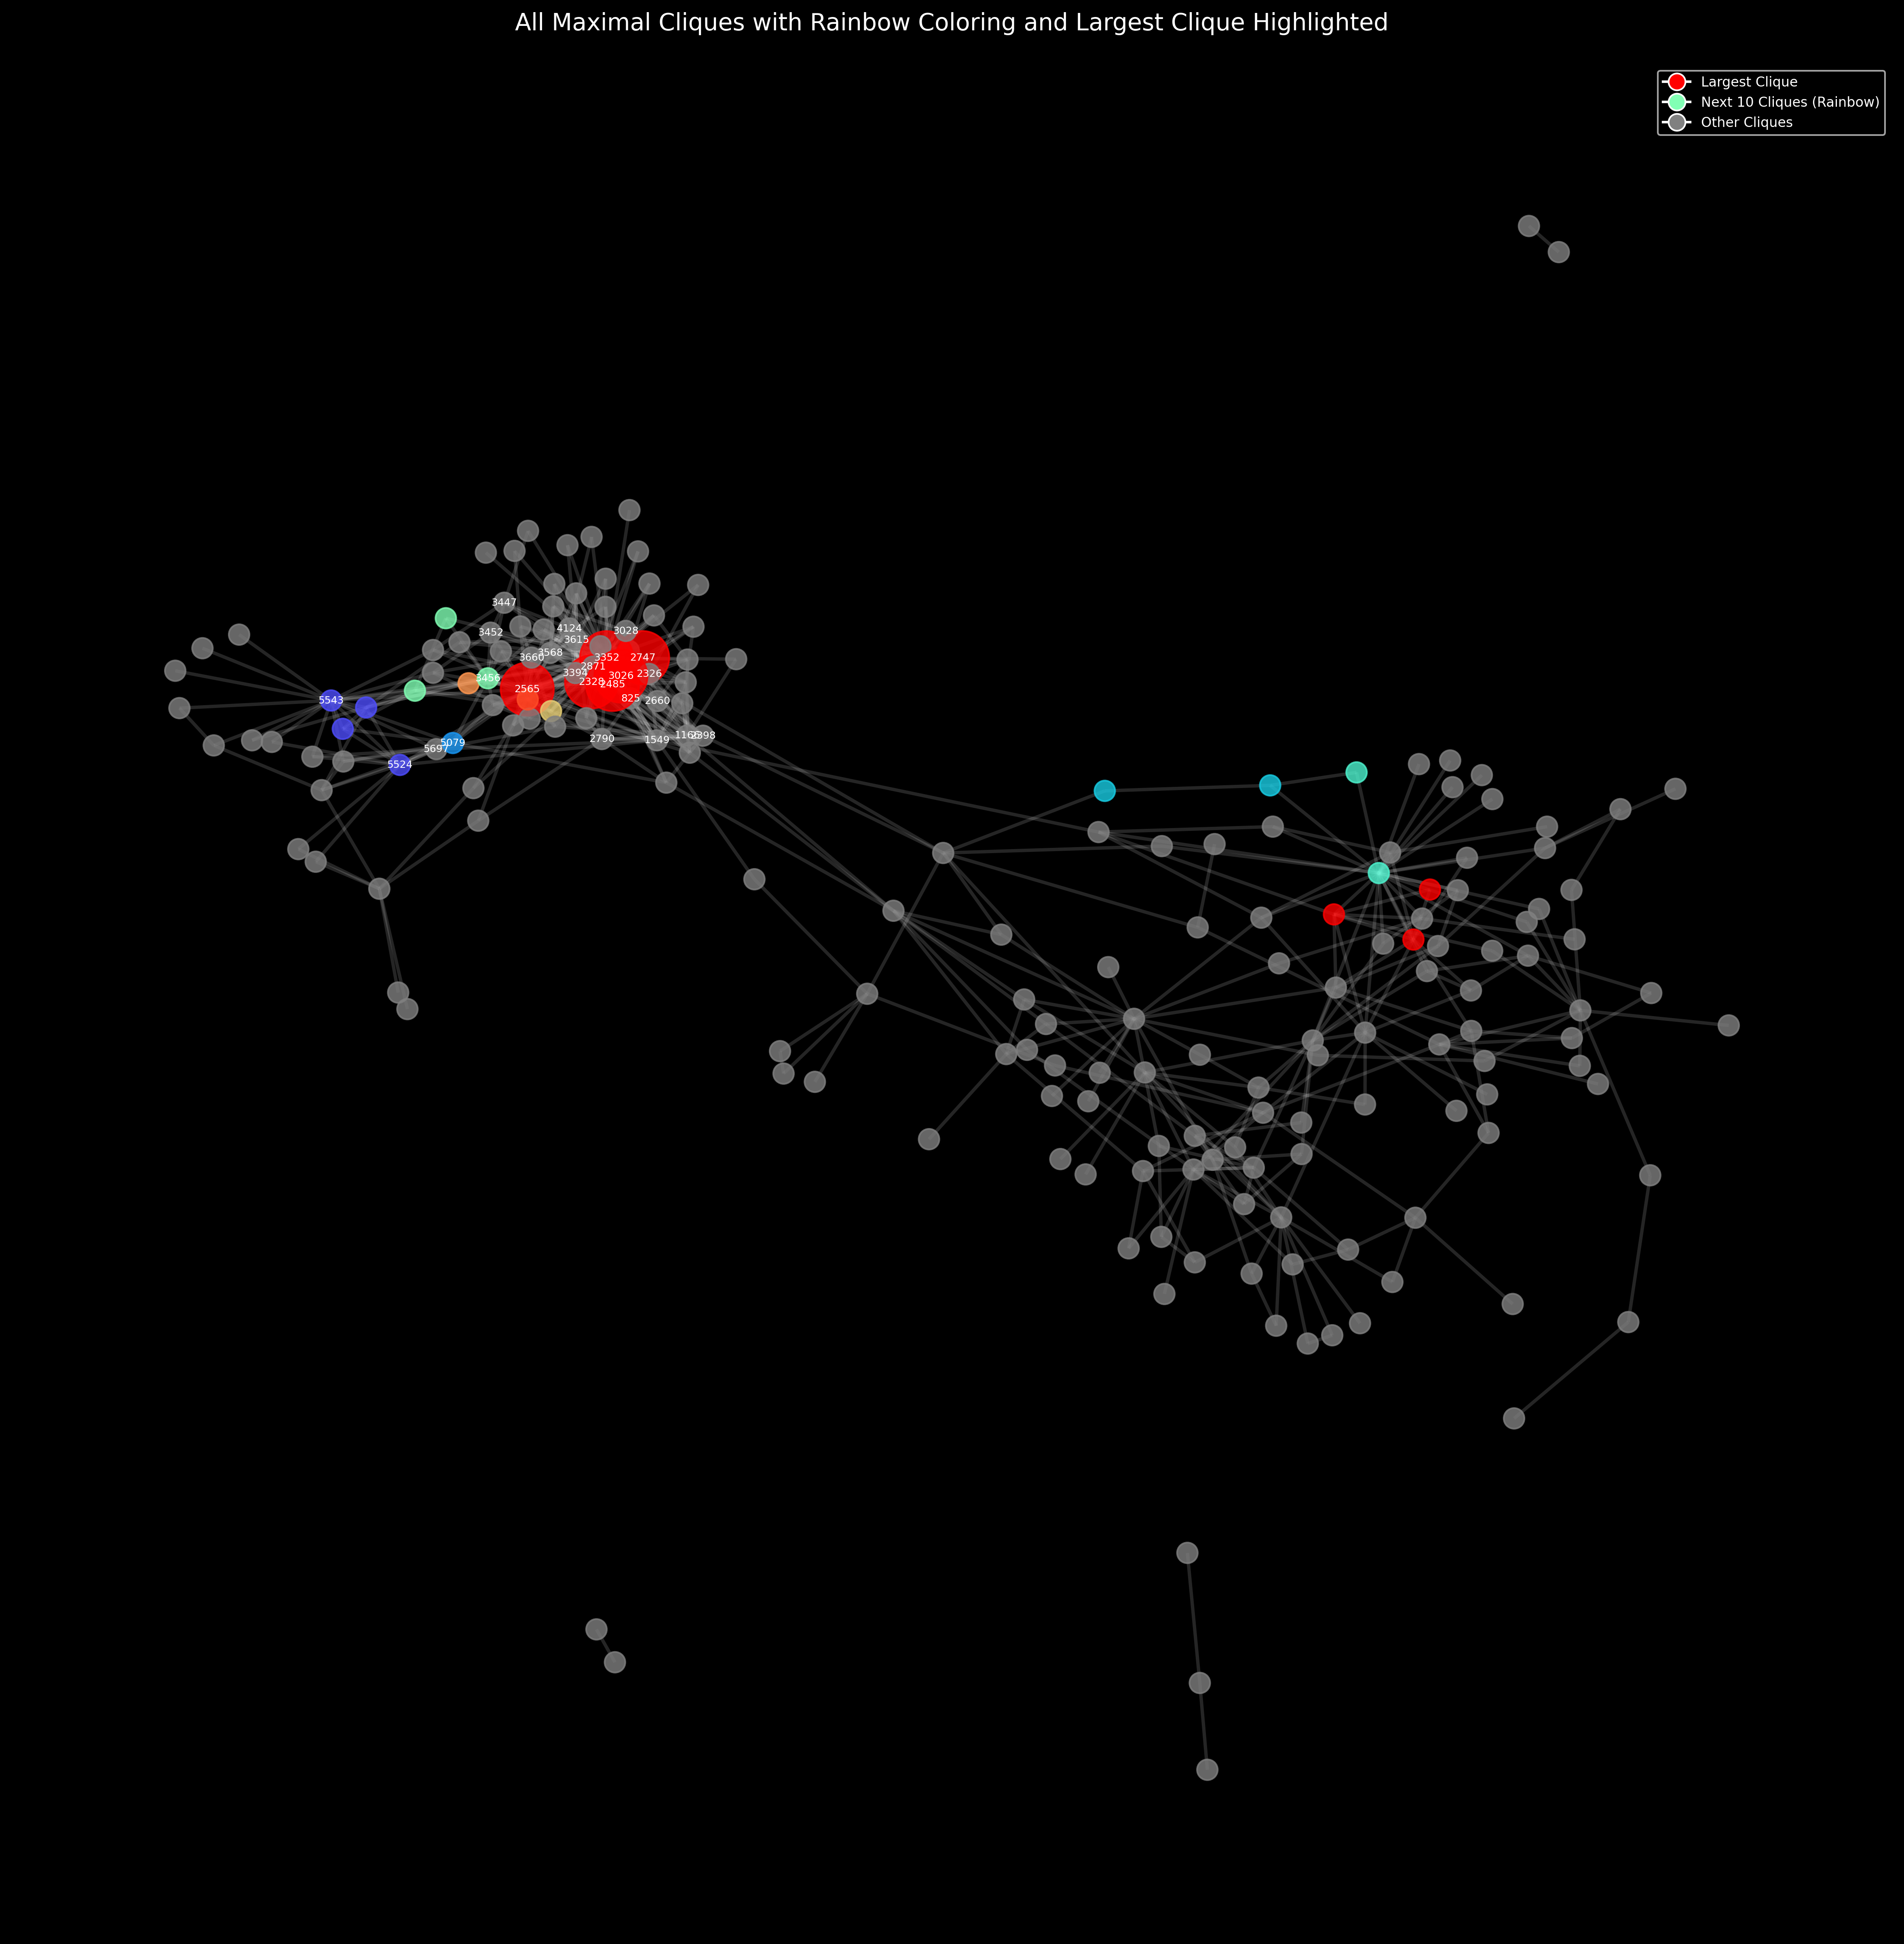

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# Load and prepare the graph
def load_graph(file_path):
    G = nx.DiGraph()
    with open(file_path, "r") as file:
        for line in file:
            if not line.startswith("#"):
                from_node, to_node = map(int, line.strip().split())
                G.add_edge(from_node, to_node)
    return G

# Filter the graph for reciprocal edges only
def filter_reciprocal_edges(G):
    reciprocal_edges = [(u, v) for u, v in G.edges() if G.has_edge(v, u)]
    reciprocal_graph = nx.DiGraph()
    reciprocal_graph.add_edges_from(reciprocal_edges)
    return reciprocal_graph

# Convert to undirected graph for visualization
def convert_to_undirected(nx_graph):
    return nx_graph.to_undirected()

# Visualize the graph
def visualize_graph(G, visualize_all_nodes=False, num_nodes=200):
    if visualize_all_nodes:
        subgraph = G
        title = "Graph Visualization (All Nodes)"
    else:
        subgraph_nodes = list(G.nodes)[:num_nodes]
        subgraph = G.subgraph(subgraph_nodes)
        title = f"Subgraph Visualization (First {num_nodes} Nodes)"

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, k=2, iterations=1000)
    nx.draw(subgraph, pos, with_labels=True, node_size=100, font_size=3)
    plt.title(title)
    plt.show()
    return subgraph

# Bron-Kerbosch algorithm for finding cliques
def bron_kerbosch(graph, r, p, x, cliques):
    if not p and not x:
        cliques.append(r)
        return

    pivot = max((p | x), key=lambda u: len(graph[u] & p)) if p or x else None
    for v in p - (graph[pivot] if pivot else set()):
        neighbors = graph[v]
        bron_kerbosch(graph, r | {v}, p & neighbors, x & neighbors, cliques)
        p.remove(v)
        x.add(v)

# Convert to undirected adjacency for Bron-Kerbosch
def convert_to_undirected_adjacency(nx_graph):
    undirected_graph = nx_graph.to_undirected()
    adj = {node: set(undirected_graph.neighbors(node)) for node in undirected_graph.nodes()}
    return adj

# Visualize cliques with sizes emphasized
def visualize_cliques_with_rainbow(subgraph, found_cliques, largest_clique):
    plt.style.use('dark_background')
    plt.figure(figsize=(20, 20), dpi=300, facecolor='black')
    pos = nx.spring_layout(subgraph, k=2, iterations=1000)
    nx.draw_networkx_edges(subgraph, pos, edge_color='white', alpha=0.15, width=2)

    node_colors = {}
    other_cliques_color = 'gray'

    # Assign colors to the largest clique first
    for node in largest_clique:
        node_colors[node] = 'red'

    # Assign colors: next 10 cliques and others
    for idx, clique in enumerate(found_cliques):
        if idx == 0:  # Skip as largest clique is already processed
            continue
        elif 1 <= idx <= 10:  # Next 10 cliques
            color = plt.cm.rainbow(idx / 10)  # Use rainbow color scale
            for node in clique:
                if node not in node_colors:  # Avoid overwriting largest clique colors
                    node_colors[node] = color
        else:  # All other cliques
            for node in clique:
                if node not in node_colors:  # Avoid overwriting existing colors
                    node_colors[node] = other_cliques_color

    # Set node sizes and colors for visualization
    node_color_list = [node_colors.get(node, other_cliques_color) for node in subgraph.nodes()]
    node_size_list = [1000 if node in largest_clique else 150 for node in subgraph.nodes()]  # Increase size for largest clique nodes
    
    # Add labels for the largest clique by size and the next 10 cliques
    labels = {}
    found_cliques_sorted = sorted(found_cliques, key=len, reverse=True)  # Sort cliques by size
    for idx, clique in enumerate(found_cliques_sorted):
        if 0 <= idx <= 10:  # Include the largest clique and the next 10 cliques
            for node in clique:  # Limit to the first 10 nodes in each clique
                labels[node] = str(node)

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size_list, node_color=node_color_list, alpha=0.8)
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=6, font_color='white', font_weight='light')

    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Largest Clique', markersize=10, markerfacecolor='red'),
        plt.Line2D([0], [0], marker='o', color='w', label='Next 10 Cliques (Rainbow)', markersize=10, markerfacecolor=plt.cm.rainbow(0.5)),
        plt.Line2D([0], [0], marker='o', color='w', label='Other Cliques', markersize=10, markerfacecolor=other_cliques_color),
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=8)

    plt.title("All Maximal Cliques with Rainbow Coloring and Largest Clique Highlighted", color='white', pad=20, size=14)
    plt.axis('off')
    plt.show()

# Generate a summary of the graph
def graph_summary(G, largest_clique):
    print("Graph Summary:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")
    print(f"- Largest clique size: {len(largest_clique)}")
    print(f"- Nodes in the largest clique: {sorted(largest_clique)}")

# Main Execution
file_path = "Data/Wiki-Vote.txt"
G = load_graph(file_path)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Filter for reciprocal edges
G_reciprocal = filter_reciprocal_edges(G)
print(f"Graph after filtering has {G_reciprocal.number_of_nodes()} nodes and {G_reciprocal.number_of_edges()} reciprocal edges.")

print(G_reciprocal.edges)
# Convert the graph to undirected for visualization
G_undirected = convert_to_undirected(G_reciprocal)

reciprocal_nodes = list(G_reciprocal.nodes())[:200]
recipGraph = G_undirected.subgraph(reciprocal_nodes)

# Toggle this flag to visualize all nodes or a subgraph
visualize_all_nodes = False
subgraph = visualize_graph(recipGraph, visualize_all_nodes=visualize_all_nodes)

adj_graph = convert_to_undirected_adjacency(subgraph)

found_cliques = []
bron_kerbosch(adj_graph, set(), set(adj_graph.keys()), set(), found_cliques)

largest_clique = max(found_cliques, key=len)

# Generate summary
graph_summary(recipGraph, largest_clique)

# Visualize
visualize_cliques_with_rainbow(subgraph, found_cliques, largest_clique)
